## Let's try NN

In [70]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torchvision


In [71]:
DATA_DIR = "./generated_data"
CSV_NAME = "generated_data_1.csv"

## Merge CSVs

In [150]:
df = pd.read_csv(os.path.join(DATA_DIR, CSV_NAME))
# df = pd.DataFrame()
# for csv_name in os.listdir(DATA_DIR):
#     if csv_name == CSV_NAME:
#         continue
#     df = pd.concat([df, pd.read_csv(os.path.join(DATA_DIR, csv_name))], axis=0, ignore_index = True)    

df = df.dropna(axis=1) # to prevent nan in model output
df.drop_duplicates()
df.head()

,noisy motion,kalman prediction,ground truth,motion noise stdev,laser noise stdev,laser range 1,laser range 2,laser range 3,laser range 4,laser range 5,laser range 6
0,-1.155220,3.551487,3.268738,2,0.01,6.463386,6.457985,6.450579,6.449560,6.465331,6.462147
1,-0.344686,3.759194,3.941828,2,0.01,6.305038,6.282087,6.263595,6.265825,6.249935,6.243805
2,-0.265481,4.417085,4.019310,2,0.01,5.602849,5.594613,5.582178,5.580036,5.585974,5.587743
3,0.465647,4.499272,4.404337,2,0.01,5.538476,5.515565,5.505001,5.503956,5.516458,5.535148
4,0.182628,4.881963,4.111349,2,0.01,5.140490,5.114725,5.125316,5.132672,5.123336,5.125902


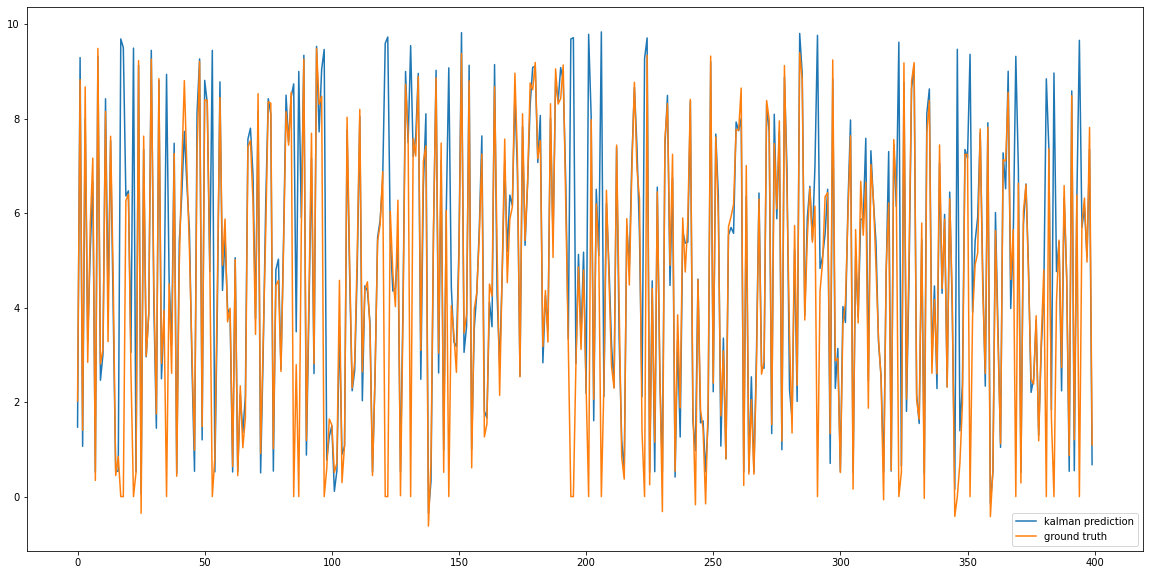

In [188]:
# # sanity checks

# # kf_pred = torch.tensor(df['kalman prediction'].to_list()).reshape(-1, 1)
# # gt = torch.tensor(df['ground truth'].to_list()).reshape(-1, 1)

# split = 400


# plt.figure(figsize=(20, 10))
# plt.plot(df['kalman prediction'].to_list()[:split])
# plt.plot(df['ground truth'].to_list()[:split])
# # plt.plot(test_pred[:split])

# # plt.legend(['kalman prediction', 'ground truth', 'rnn prediction'])
# # plt.plot(pred.to_list())




# Split
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)



# sanity checks

# kf_pred = torch.tensor(df['kalman prediction'].to_list()).reshape(-1, 1)
# gt = torch.tensor(df['ground truth'].to_list()).reshape(-1, 1)

split = 400


plt.figure(figsize=(20, 10))
plt.plot(train_df['kalman prediction'].to_list()[:split])
plt.plot(train_df['ground truth'].to_list()[:split])

plt.legend(['kalman prediction', 'ground truth', 'rnn prediction'])




In [156]:
# len(df)
len(df.index.unique()), len(df.index)

(1050, 1050)

In [157]:

# train_idx = np.sav
# test_df = df.drop(~df.index.isin(train_df.index))

# create test_df for rows not in train_df
# test_df = pd.DataFrame()
# for idx, row in df.iterrows():
#     if idx not in train_df.iterrows():
#         test_df.loc[idx] = row

# # train_df.head()
# test_df.head()

In [158]:
len(train_df.index.unique()), len(train_df.index), len(test_df.index.unique()), len(test_df.index)

(840, 840, 210, 210)

In [159]:
os.makedirs('./csv', exist_ok=True)
train_df.to_csv("./csv/train_1d.csv", index=False)
test_df.to_csv("./csv/test_1d.csv", index=False)


## Gear Up | Train | Launch

In [160]:
batch_size = 10

In [161]:
input_df = train_df.drop(columns=["ground truth", "kalman prediction"])
output_df = train_df["ground truth"]
# print(input_df.shape)
# torch cvs loader
dataset = torch.utils.data.TensorDataset(torch.from_numpy(input_df.to_numpy()).type(torch.float32), torch.from_numpy(output_df.to_numpy()).type(torch.float32))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [162]:
x = next(iter(dataloader))
x[0].shape, x[1].shape

(torch.Size([10, 9]), torch.Size([10]))

In [163]:
# input_size = 9
# output_size = 1
# hidden_size = 512
# lr = 0.0001


input_size = 9
output_size = 1 
hidden_size = [64, 32, 16, 8, 4, 2, output_size]

model = torchvision.ops.MLP(in_channels=input_size, hidden_channels=hidden_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model = SimpleRNN(input_size, hidden_size, output_size).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
# criterion_l1 = nn.L1Loss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)





In [177]:
# Train the model
loss_cache = []


num_epochs = 400
for epoch in range(num_epochs):
    # hidden layer of the last batch
    # prev_batch_hidden = torch.zeros((1, input_data[0].size(0), hidden_size)).to(device)

    for inputs, outputs in dataloader:
        outputs = outputs.view(-1, 1)
        optimizer.zero_grad()
        pred = model(inputs)
        # print(pred.shape, outputs.shape)
        # prev_batch_hidden = 
        loss = criterion(pred, outputs)
        loss.backward()
        optimizer.step()
    lr_scheduler.step()
    loss_cache.append(loss.item())
    # Print the loss after every epoch
    if epoch %10 ==0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))



Epoch [1/400], Loss: 10.0188
Epoch [11/400], Loss: 0.7976
Epoch [21/400], Loss: 0.4119
Epoch [31/400], Loss: 9.4953
Epoch [41/400], Loss: 0.1662
Epoch [51/400], Loss: 3.3584
Epoch [61/400], Loss: 0.2472
Epoch [71/400], Loss: 0.1883
Epoch [81/400], Loss: 0.5071
Epoch [91/400], Loss: 0.6781
Epoch [101/400], Loss: 1.8486
Epoch [111/400], Loss: 0.2041
Epoch [121/400], Loss: 0.9696
Epoch [131/400], Loss: 0.1292
Epoch [141/400], Loss: 0.1085
Epoch [151/400], Loss: 0.1986
Epoch [161/400], Loss: 0.2036
Epoch [171/400], Loss: 0.3499
Epoch [181/400], Loss: 0.1059
Epoch [191/400], Loss: 0.1547
Epoch [201/400], Loss: 1.0877
Epoch [211/400], Loss: 0.1853
Epoch [221/400], Loss: 0.0973
Epoch [231/400], Loss: 1.6389
Epoch [241/400], Loss: 6.6932
Epoch [251/400], Loss: 0.1612
Epoch [261/400], Loss: 1.3643
Epoch [271/400], Loss: 5.4788
Epoch [281/400], Loss: 0.1056
Epoch [291/400], Loss: 0.4606
Epoch [301/400], Loss: 6.4159
Epoch [311/400], Loss: 3.0521
Epoch [321/400], Loss: 1.0591
Epoch [331/400], Los

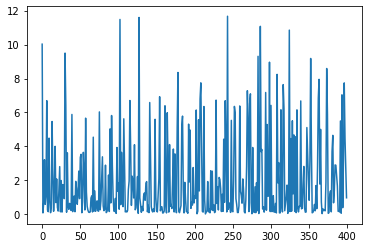

In [178]:
plt.plot(loss_cache)

In [179]:
test_input_df = test_df.drop(columns=["ground truth", "kalman prediction"])
test_output_df = test_df["ground truth"]
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_input_df.to_numpy()).type(torch.float32), torch.from_numpy(test_output_df.to_numpy()).type(torch.float32))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

loss_cache = []
test_pred = []
with torch.no_grad():
    for inputs, outputs in test_dataloader:
        outputs = outputs.view(-1, 1)
        pred = model(inputs)
        test_pred.append(pred)
        loss = criterion(pred, outputs)
        # print(loss.item())
        loss_cache.append(loss.item())

In [180]:

# reshape test_pred to 1d
test_pred = torch.cat(test_pred, dim=0)

In [181]:
# test_pred

## MSE between Kalman prediction and Ground Truth

In [182]:
kf_pred = torch.tensor(test_df['kalman prediction'].to_list()).reshape(-1, 1)
gt = torch.tensor(test_df['ground truth'].to_list()).reshape(-1, 1)

gt.shape, kf_pred.shape

(torch.Size([210, 1]), torch.Size([210, 1]))

In [183]:
# mse between kf_pred and gt
criterion(kf_pred, gt), sum(loss_cache)

(tensor(3.6367), 37.51551004499197)

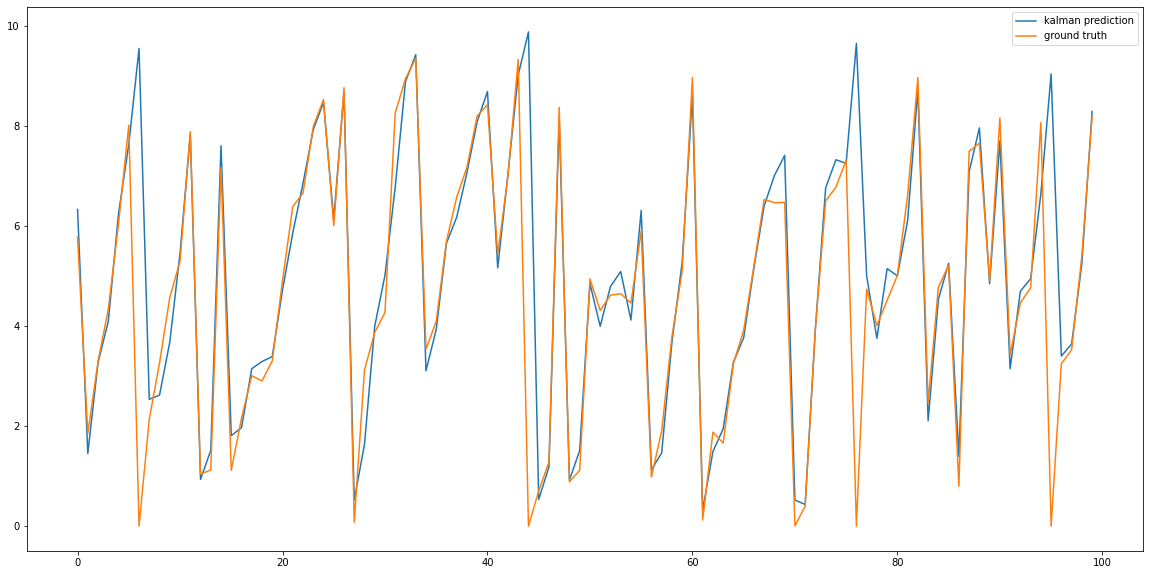

In [186]:
split = 100


plt.figure(figsize=(20, 10))
plt.plot(test_df['kalman prediction'].to_list()[:split])
plt.plot(test_df['ground truth'].to_list()[:split])
plt.plot(test_pred[:split])

plt.legend(['kalman prediction', 'ground truth', 'rnn prediction'])
# plt.plot(pred.to_list())

